***
    
Demo JAX for PINN (Physics-Informed Neural Network)
    
***

    Version: 2023-03-16
    
    Author : Nicholas Sung Wei Yong, Wong Jian Cheng, Ooi Chin Chun, Abhishek Gupta

    Contain:
    
    1. PINN for solving Korteweg–De Vries equation
    
    2. Optimize PINN using Stochastic gradient descent on the JAX framework
       -  as described in Nicholas Sung Wei Yong, Jian Cheng Wong, Pao-Hsiung Chiu, Abhishek Gupta, Chinchun Ooi, Yew-Soon Ong
       "Neuroevolution Surpasses Stochastic Gradient Descent for Physics-Informed Neural Networks" arXiv preprint arXiv:2212.07624 (2022).

Import Libraries

In [1]:
import jax
import optax
import time
import matplotlib.pyplot as plt
from typing import Any, Callable, Sequence, Optional
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax.config import config

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

PINN Architecture

In [2]:
node = 8
class PINNs(nn.Module):
    """PINNs"""
    def setup(self):
        self.layers = [nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform(), use_bias=False),
                       nn.tanh,
                       nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform()),
                       nn.tanh,
                       nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform()),
                       nn.tanh,
                       nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform()),
                       nn.tanh,                       
                       nn.Dense(1, kernel_init = jax.nn.initializers.glorot_uniform(), use_bias=False)]
    
    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        x, t = inputs[:,0:1], inputs[:,1:2]
        
        def get_u(x, t):
            u = jnp.hstack([x, t])
            for i, lyr in enumerate(self.layers):
                u = lyr(u)
            return u
        
        u = get_u(x, t)
        
        # obtain u_t
        def get_u_t(get_u, x, t):
            u_t = jacfwd(get_u, 1)(x, t)
            return u_t
    
        u_t_vmap = vmap(get_u_t, in_axes=(None, 0, 0))
        u_t = u_t_vmap(get_u, x, t).reshape(-1,1) 
        
        # obtain u_x
        def get_u_x(get_u, x, t):
            u_x = jacfwd(get_u)(x, t)
            return u_x
        
        u_x_vmap = vmap(get_u_x, in_axes=(None, 0, 0))
        u_x = u_x_vmap(get_u, x, t).reshape(-1,1)  
        
        # obtain u_xx    
        def get_u_xx(get_u, x, t):
            u_xx = hessian(get_u)(x, t)
            return u_xx
        
        u_xx_vmap = vmap(get_u_xx, in_axes=(None, 0, 0))
        u_xx = u_xx_vmap(get_u, x, t).reshape(-1,1)
        
        # obtain u_xxx    
        def get_u_xxx(get_u, x, t):
            u_xxx = third_deriviative(get_u)(x, t)
            return u_xxx
        u_xxx_vmap = vmap(get_u_xxx, in_axes=(None, 0, 0))
        u_xxx = u_xxx_vmap(get_u, x, t).reshape(-1,1)        
        
        action = jnp.hstack([u, u_x, u_xx, u_xxx, u_t])   
        return action

def third_deriviative(f):
    return jacfwd(jacfwd(jacfwd(f)))    
    
# initialize model
model = PINNs()    

In [3]:
# choose seed
seed = 1
key1, key2 = random.split(random.PRNGKey(seed))
a = random.normal(key1, [1,2]) # Dummy input
params = model.init(key2, a) # Initialization call

In [4]:
from evojax.util import get_params_format_fn
num_params, format_params_fn = get_params_format_fn(params)
num_params

240

Problem

In [5]:
def f_ic(x):
    return 3*c1*(1 / jnp.cosh(a1*(x-x1)))**2 + 3*c2*(1 / jnp.cosh(a2*(x-x2)))**2

Hyper parameters and data 

In [6]:
import numpy as np
import pandas as pd

In [7]:
v1 = 1
v2 = 0.001

# initial condition
c1, c2, x1, x2 = 0.3, 0.1, 0.4, 0.8
a1, a2 = 0.5*jnp.sqrt(c1/v2), 0.5*jnp.sqrt(c2/v2)

# spatial domain
x_l, x_u = 0., 1.5

# time domain: 0 - t_T
t_T = 2.0

sim = pd.read_csv('kdv.csv')
sim['x'], sim['t'] = sim['x'], sim['t']
x_train = jnp.vstack([sim.x.values, sim.t.values]).T
y_train = sim[['u']].values
domain = (x_train[:,0] >= 0.0) & (x_train[:,0] <= 1.5)
x_train, y_train = x_train[domain], y_train[domain]
x = x_train[:,0:1].reshape(-1,1)
t = x_train[:,1:2].reshape(-1,1)

_train1 = np.argwhere(t != 0.0)[:, 0]
x_train1 = x[_train1].reshape(-1,1)
t_train1 = t[_train1].reshape(-1,1)
y_train1 = y_train[_train1].reshape(-1,1)

_train2 = np.argwhere(t == 0.0)[:, 0]
x_train2 = x[_train2].reshape(-1,1)
t_train2 = t[_train2].reshape(-1,1)
y_train2 = y_train[_train2].reshape(-1,1)

data_all = jnp.hstack([x,t])
label_all = y_train
data_pde = jnp.hstack([x_train1, t_train1])
label_pde = y_train1
data_bc = jnp.hstack([x_train2, t_train2])
label_bc = y_train2
label_pde.shape[0]

15400

Loss Function

In [8]:
# loss function parameter
lmbda = 1 #500

In [9]:
def loss(params, inputs):
    x = inputs[:,0:1].reshape(-1,1)
    t = inputs[:,1:2].reshape(-1,1)
    prediction = model.apply(format_params_fn(params), jnp.hstack([x, t]))
    u, u_x, u_xx, u_xxx, u_t = prediction[:,0:1], prediction[:,1:2], prediction[:,2:3], prediction[:,3:4], prediction[:,4:5]
    # ground truth
    t_u = f_ic(x) 
    _ic = jnp.where((jnp.equal(t, 0)), 1, 0)
    # _bc = ( jnp.equal(x, x_l) | jnp.equal(x, x_u) )
    ic_mse = jnp.sum(jnp.square((t_u - u)*_ic)) / jnp.sum(_ic)
    # PDE (physics laws) 
    pde = u_t + v1*u*u_x + v2*u_xxx
    # exclude BC points
    _pde = jnp.where((jnp.equal(t, 0)), 0, 1)
    pde = pde * _pde
    pde_mse = jnp.sum(jnp.square(pde)) / jnp.sum(_pde)
    pde_mse = pde_mse 
    loss = pde_mse + ic_mse    
    return loss
  
#loss_grad = jax.jit(jax.grad(loss))
loss_grad = jax.jit(jax.value_and_grad(loss))    

Weights Update

In [10]:
def update(params, opt_state, batch_data):
    loss_value, grad = loss_grad(params, batch_data)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

update = jit(update)

Initialization

In [11]:
# initial params
params = model.init(key2, a) # Initialization call

# flatten initial params
params = jax.flatten_util.ravel_pytree(params)[0]

Optimizer (SGD)

In [12]:
alpha = 0.1
optimizer = optax.sgd(learning_rate=alpha)
opt_state = optimizer.init(params)

Minibatching

In [13]:
BS_pde = 100
BS_bc = 5

def minibatch(train_iters):
    _batch_pde = jax.random.choice(random.PRNGKey(train_iters), label_pde.shape[0], (BS_pde,))
    _batch_bc = jax.random.choice(random.PRNGKey(train_iters), label_bc.shape[0], (BS_bc,))    
    batch_data = jnp.vstack([data_pde[_batch_pde], data_bc[_batch_bc]])
    return batch_data

minibatch = jit(minibatch)

Training 

In [14]:
# store weights
papas = {}
papas[0] = params

max_iters = 1500000
minloss = jnp.inf
fullbatchloss = jnp.inf
fullbatchloss_ls = []
runtime = 0
train_iters = 0
while (train_iters < max_iters) and (runtime < 60):
    # compute full batch loss (every 1 iterations)
    if (train_iters % 1 == 0):
        loss_value, _ = loss_grad(params, data_all)    
        fullbatchloss = min(fullbatchloss, loss_value)
    # mini-batching
    batch_data = minibatch(train_iters)
    # stochastic update
    start = time.time()
    params, opt_state, loss_value = update(params, opt_state, batch_data)
    end = time.time()
    # store hsitory.
    runtime += (end-start)   
    fullbatchloss_ls.append([train_iters, runtime, loss_value, fullbatchloss])
    # append weights
    save_iters = [100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]
    if (train_iters in save_iters):
        papas[train_iters] = params
        #print ('iter. = %d  time = %.2fs  loss = %.2e  min. (full batch) loss = %.2e'%(train_iters, runtime, loss_value, fullbatchloss))
    # store weights when the full-batch loss is smallest
    if fullbatchloss < minloss:
        print ('iter. = %d  time = %.2fs  loss = %.2e  min. (full batch) loss = %.2e'%(train_iters, runtime, loss_value, fullbatchloss))
        minloss = fullbatchloss
        papas[-1] = params
    train_iters += 1
              
# final train_iters
print (train_iters, minloss)

iter. = 0  time = 2.38s  loss = 7.84e-02  min. (full batch) loss = 1.47e-01
iter. = 1  time = 2.39s  loss = 7.34e-02  min. (full batch) loss = 9.17e-02
iter. = 5  time = 2.39s  loss = 9.78e-02  min. (full batch) loss = 6.34e-02
iter. = 7  time = 2.39s  loss = 1.05e-01  min. (full batch) loss = 6.11e-02
iter. = 12  time = 2.39s  loss = 4.74e-02  min. (full batch) loss = 5.59e-02
iter. = 36  time = 2.40s  loss = 8.18e-02  min. (full batch) loss = 5.43e-02
iter. = 43  time = 2.41s  loss = 1.76e-02  min. (full batch) loss = 5.35e-02
iter. = 50  time = 2.41s  loss = 2.56e-02  min. (full batch) loss = 5.29e-02
iter. = 73  time = 2.42s  loss = 8.21e-02  min. (full batch) loss = 5.21e-02
iter. = 82  time = 2.43s  loss = 1.79e-02  min. (full batch) loss = 5.17e-02
iter. = 92  time = 2.43s  loss = 5.96e-03  min. (full batch) loss = 5.13e-02
iter. = 113  time = 2.44s  loss = 3.02e-02  min. (full batch) loss = 5.09e-02
iter. = 121  time = 2.45s  loss = 1.00e-01  min. (full batch) loss = 5.06e-02
i

iter. = 1020  time = 2.92s  loss = 5.93e-03  min. (full batch) loss = 2.30e-02
iter. = 1048  time = 2.94s  loss = 5.04e-03  min. (full batch) loss = 2.30e-02
iter. = 1053  time = 2.94s  loss = 5.90e-03  min. (full batch) loss = 2.26e-02
iter. = 1062  time = 2.95s  loss = 4.28e-02  min. (full batch) loss = 2.26e-02
iter. = 1072  time = 2.95s  loss = 7.05e-03  min. (full batch) loss = 2.25e-02
iter. = 1073  time = 2.95s  loss = 1.46e-02  min. (full batch) loss = 2.25e-02
iter. = 1074  time = 2.95s  loss = 1.07e-02  min. (full batch) loss = 2.24e-02
iter. = 1083  time = 2.96s  loss = 4.49e-02  min. (full batch) loss = 2.23e-02
iter. = 1088  time = 2.96s  loss = 1.17e-02  min. (full batch) loss = 2.21e-02
iter. = 1098  time = 2.97s  loss = 1.13e-02  min. (full batch) loss = 2.19e-02
iter. = 1117  time = 2.98s  loss = 1.46e-02  min. (full batch) loss = 2.19e-02
iter. = 1118  time = 2.98s  loss = 9.41e-03  min. (full batch) loss = 2.19e-02
iter. = 1130  time = 2.99s  loss = 4.80e-02  min. (f

iter. = 2364  time = 3.66s  loss = 9.60e-03  min. (full batch) loss = 1.41e-02
iter. = 2377  time = 3.66s  loss = 2.00e-02  min. (full batch) loss = 1.41e-02
iter. = 2409  time = 3.68s  loss = 2.12e-02  min. (full batch) loss = 1.40e-02
iter. = 2418  time = 3.68s  loss = 2.32e-02  min. (full batch) loss = 1.40e-02
iter. = 2431  time = 3.69s  loss = 6.45e-03  min. (full batch) loss = 1.38e-02
iter. = 2433  time = 3.69s  loss = 1.22e-02  min. (full batch) loss = 1.37e-02
iter. = 2451  time = 3.70s  loss = 2.75e-02  min. (full batch) loss = 1.37e-02
iter. = 2458  time = 3.71s  loss = 1.17e-02  min. (full batch) loss = 1.37e-02
iter. = 2473  time = 3.71s  loss = 1.07e-02  min. (full batch) loss = 1.36e-02
iter. = 2481  time = 3.72s  loss = 6.09e-03  min. (full batch) loss = 1.36e-02
iter. = 2486  time = 3.72s  loss = 1.46e-02  min. (full batch) loss = 1.36e-02
iter. = 2494  time = 3.73s  loss = 2.12e-02  min. (full batch) loss = 1.35e-02
iter. = 2504  time = 3.73s  loss = 2.58e-02  min. (f

iter. = 4323  time = 4.71s  loss = 7.80e-03  min. (full batch) loss = 8.85e-03
iter. = 4335  time = 4.71s  loss = 1.85e-02  min. (full batch) loss = 8.77e-03
iter. = 4344  time = 4.72s  loss = 7.44e-03  min. (full batch) loss = 8.75e-03
iter. = 4367  time = 4.73s  loss = 7.15e-03  min. (full batch) loss = 8.72e-03
iter. = 4389  time = 4.74s  loss = 1.40e-02  min. (full batch) loss = 8.71e-03
iter. = 4417  time = 4.75s  loss = 9.08e-03  min. (full batch) loss = 8.61e-03
iter. = 4426  time = 4.76s  loss = 9.50e-03  min. (full batch) loss = 8.60e-03
iter. = 4429  time = 4.76s  loss = 2.92e-03  min. (full batch) loss = 8.56e-03
iter. = 4438  time = 4.76s  loss = 5.99e-03  min. (full batch) loss = 8.52e-03
iter. = 4452  time = 4.77s  loss = 1.00e-02  min. (full batch) loss = 8.45e-03
iter. = 4459  time = 4.77s  loss = 4.30e-03  min. (full batch) loss = 8.42e-03
iter. = 4485  time = 4.79s  loss = 7.67e-03  min. (full batch) loss = 8.33e-03
iter. = 4488  time = 4.79s  loss = 7.27e-03  min. (f

iter. = 6342  time = 5.77s  loss = 3.39e-03  min. (full batch) loss = 5.10e-03
iter. = 6361  time = 5.78s  loss = 5.37e-03  min. (full batch) loss = 5.08e-03
iter. = 6379  time = 5.79s  loss = 4.73e-03  min. (full batch) loss = 5.07e-03
iter. = 6413  time = 5.81s  loss = 2.16e-03  min. (full batch) loss = 5.06e-03
iter. = 6431  time = 5.82s  loss = 5.71e-03  min. (full batch) loss = 5.04e-03
iter. = 6442  time = 5.82s  loss = 3.26e-03  min. (full batch) loss = 5.01e-03
iter. = 6534  time = 5.87s  loss = 5.34e-03  min. (full batch) loss = 5.01e-03
iter. = 6546  time = 5.88s  loss = 7.09e-03  min. (full batch) loss = 4.97e-03
iter. = 6551  time = 5.88s  loss = 4.13e-03  min. (full batch) loss = 4.93e-03
iter. = 6612  time = 5.91s  loss = 4.80e-03  min. (full batch) loss = 4.93e-03
iter. = 6613  time = 5.91s  loss = 4.62e-03  min. (full batch) loss = 4.92e-03
iter. = 6664  time = 5.94s  loss = 4.37e-03  min. (full batch) loss = 4.89e-03
iter. = 6698  time = 5.95s  loss = 2.76e-03  min. (f

iter. = 9556  time = 7.50s  loss = 4.20e-03  min. (full batch) loss = 3.06e-03
iter. = 9557  time = 7.50s  loss = 3.33e-03  min. (full batch) loss = 3.06e-03
iter. = 9564  time = 7.51s  loss = 2.41e-03  min. (full batch) loss = 3.04e-03
iter. = 9596  time = 7.52s  loss = 4.00e-03  min. (full batch) loss = 3.02e-03
iter. = 9645  time = 7.54s  loss = 3.36e-03  min. (full batch) loss = 3.01e-03
iter. = 9706  time = 7.58s  loss = 4.15e-03  min. (full batch) loss = 2.99e-03
iter. = 9729  time = 7.59s  loss = 2.31e-03  min. (full batch) loss = 2.98e-03
iter. = 9731  time = 7.59s  loss = 2.56e-03  min. (full batch) loss = 2.98e-03
iter. = 9782  time = 7.62s  loss = 2.70e-03  min. (full batch) loss = 2.98e-03
iter. = 9784  time = 7.62s  loss = 2.48e-03  min. (full batch) loss = 2.95e-03
iter. = 9814  time = 7.63s  loss = 3.24e-03  min. (full batch) loss = 2.95e-03
iter. = 9861  time = 7.66s  loss = 3.74e-03  min. (full batch) loss = 2.95e-03
iter. = 9879  time = 7.67s  loss = 4.00e-03  min. (f

iter. = 15325  time = 10.64s  loss = 1.87e-03  min. (full batch) loss = 1.86e-03
iter. = 15356  time = 10.66s  loss = 1.84e-03  min. (full batch) loss = 1.86e-03
iter. = 15450  time = 10.71s  loss = 1.43e-03  min. (full batch) loss = 1.85e-03
iter. = 15452  time = 10.71s  loss = 9.72e-04  min. (full batch) loss = 1.85e-03
iter. = 15492  time = 10.73s  loss = 1.52e-03  min. (full batch) loss = 1.84e-03
iter. = 15515  time = 10.74s  loss = 1.81e-03  min. (full batch) loss = 1.83e-03
iter. = 15554  time = 10.76s  loss = 2.25e-03  min. (full batch) loss = 1.83e-03
iter. = 15569  time = 10.77s  loss = 1.39e-03  min. (full batch) loss = 1.81e-03
iter. = 15676  time = 10.83s  loss = 1.50e-03  min. (full batch) loss = 1.81e-03
iter. = 15880  time = 10.93s  loss = 1.47e-03  min. (full batch) loss = 1.81e-03
iter. = 15941  time = 10.96s  loss = 1.67e-03  min. (full batch) loss = 1.79e-03
iter. = 16037  time = 11.01s  loss = 2.03e-03  min. (full batch) loss = 1.78e-03
iter. = 16046  time = 11.01s

iter. = 24669  time = 15.53s  loss = 1.49e-03  min. (full batch) loss = 1.16e-03
iter. = 24696  time = 15.54s  loss = 1.60e-03  min. (full batch) loss = 1.16e-03
iter. = 24863  time = 15.64s  loss = 9.79e-04  min. (full batch) loss = 1.16e-03
iter. = 24896  time = 15.66s  loss = 1.26e-03  min. (full batch) loss = 1.15e-03
iter. = 24982  time = 15.71s  loss = 9.76e-04  min. (full batch) loss = 1.14e-03
iter. = 25131  time = 15.80s  loss = 9.11e-04  min. (full batch) loss = 1.14e-03
iter. = 25163  time = 15.82s  loss = 8.93e-04  min. (full batch) loss = 1.14e-03
iter. = 25231  time = 15.86s  loss = 8.18e-04  min. (full batch) loss = 1.13e-03
iter. = 25519  time = 16.02s  loss = 7.08e-04  min. (full batch) loss = 1.13e-03
iter. = 25543  time = 16.03s  loss = 1.61e-03  min. (full batch) loss = 1.12e-03
iter. = 25554  time = 16.04s  loss = 1.40e-03  min. (full batch) loss = 1.12e-03
iter. = 25588  time = 16.05s  loss = 1.05e-03  min. (full batch) loss = 1.12e-03
iter. = 25599  time = 16.06s

iter. = 38250  time = 22.85s  loss = 7.70e-04  min. (full batch) loss = 7.65e-04
iter. = 38335  time = 22.89s  loss = 4.78e-04  min. (full batch) loss = 7.60e-04
iter. = 38508  time = 22.98s  loss = 7.97e-04  min. (full batch) loss = 7.58e-04
iter. = 38583  time = 23.03s  loss = 5.30e-04  min. (full batch) loss = 7.58e-04
iter. = 38660  time = 23.07s  loss = 6.89e-04  min. (full batch) loss = 7.51e-04
iter. = 38750  time = 23.12s  loss = 5.42e-04  min. (full batch) loss = 7.50e-04
iter. = 38822  time = 23.16s  loss = 8.43e-04  min. (full batch) loss = 7.45e-04
iter. = 39674  time = 23.61s  loss = 8.18e-04  min. (full batch) loss = 7.45e-04
iter. = 39723  time = 23.64s  loss = 7.28e-04  min. (full batch) loss = 7.39e-04
iter. = 39855  time = 23.71s  loss = 5.35e-04  min. (full batch) loss = 7.36e-04
iter. = 40036  time = 23.80s  loss = 4.89e-04  min. (full batch) loss = 7.26e-04
iter. = 40348  time = 23.97s  loss = 7.46e-04  min. (full batch) loss = 7.22e-04
iter. = 40485  time = 24.03s

iter. = 57962  time = 33.43s  loss = 5.58e-04  min. (full batch) loss = 4.94e-04
iter. = 58366  time = 33.65s  loss = 3.05e-04  min. (full batch) loss = 4.92e-04
iter. = 58440  time = 33.68s  loss = 5.70e-04  min. (full batch) loss = 4.90e-04
iter. = 58528  time = 33.73s  loss = 5.44e-04  min. (full batch) loss = 4.87e-04
iter. = 58632  time = 33.78s  loss = 4.95e-04  min. (full batch) loss = 4.87e-04
iter. = 59085  time = 34.04s  loss = 4.48e-04  min. (full batch) loss = 4.86e-04
iter. = 59091  time = 34.04s  loss = 4.18e-04  min. (full batch) loss = 4.83e-04
iter. = 59677  time = 34.35s  loss = 4.41e-04  min. (full batch) loss = 4.82e-04
iter. = 59841  time = 34.43s  loss = 3.14e-04  min. (full batch) loss = 4.79e-04
iter. = 60299  time = 34.66s  loss = 4.19e-04  min. (full batch) loss = 4.76e-04
iter. = 60466  time = 34.74s  loss = 4.06e-04  min. (full batch) loss = 4.76e-04
iter. = 60841  time = 34.93s  loss = 4.27e-04  min. (full batch) loss = 4.74e-04
iter. = 60943  time = 34.99s

iter. = 88382  time = 49.70s  loss = 2.70e-04  min. (full batch) loss = 3.53e-04
iter. = 89073  time = 50.05s  loss = 3.54e-04  min. (full batch) loss = 3.52e-04
iter. = 89125  time = 50.08s  loss = 2.64e-04  min. (full batch) loss = 3.52e-04
iter. = 89438  time = 50.26s  loss = 4.38e-04  min. (full batch) loss = 3.50e-04
iter. = 89815  time = 50.44s  loss = 6.55e-04  min. (full batch) loss = 3.47e-04
iter. = 90897  time = 51.07s  loss = 2.94e-04  min. (full batch) loss = 3.46e-04
iter. = 91028  time = 51.13s  loss = 4.24e-04  min. (full batch) loss = 3.45e-04
iter. = 91031  time = 51.14s  loss = 1.81e-04  min. (full batch) loss = 3.44e-04
iter. = 91278  time = 51.26s  loss = 4.62e-04  min. (full batch) loss = 3.44e-04
iter. = 91652  time = 51.45s  loss = 3.45e-04  min. (full batch) loss = 3.43e-04
iter. = 91791  time = 51.52s  loss = 5.50e-04  min. (full batch) loss = 3.42e-04
iter. = 92152  time = 51.71s  loss = 3.71e-04  min. (full batch) loss = 3.41e-04
iter. = 93092  time = 52.24s

In [15]:
# process results
import numpy as np
import pandas as pd

In [16]:
fullbatchloss_ls = np.array(fullbatchloss_ls)
# write convergence history to file
# df = pd.DataFrame(fullbatchloss_ls, columns=[['Training Iteration', 'Training Time', 'Minibatch Loss', 'Fullbatch Loss']])
# df.to_csv('kdv_sgd_minibatch_%d.csv'%(seed), index=False)
# df
fullbatchloss_ls[-1]

array([1.07543000e+05, 6.00001917e+01, 7.21880817e-04, 3.10567324e-04])

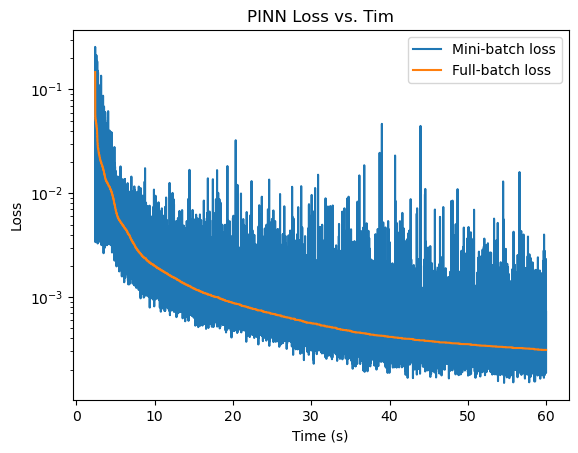

In [17]:
plt.plot(fullbatchloss_ls[:, 1], fullbatchloss_ls[:, 2], label='Mini-batch loss'); plt.yscale('log');
plt.plot(fullbatchloss_ls[:, 1], fullbatchloss_ls[:, 3], label='Full-batch loss');
plt.title('PINN Loss vs. Tim'); plt.xlabel('Time (s)'); plt.ylabel('Loss'); plt.legend();

#### Visualize results

DeviceArray(0.00069885, dtype=float32)

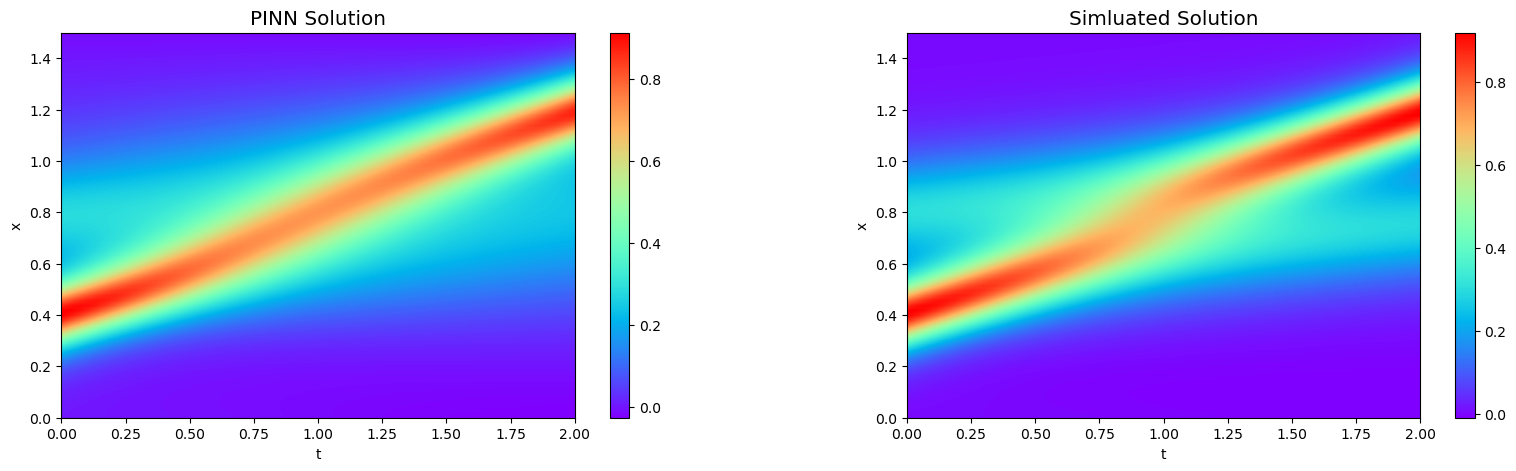

In [21]:
# plot best full-batch loss
hello = PINNs()
prediction = hello.apply(format_params_fn(papas[-1]), data_all)
u = prediction[:,0:1]

fig = plt.figure(figsize=(20, 5))
u_viz = (u.reshape(201, 77)).T 
ext = [0 ,t_T, x_l, x_u]     # plot boundary  
ax1 = fig.add_subplot(1,2,1)
mesh =ax1.imshow(u_viz, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1); 
plt.colorbar(mesh) 
plt.xlabel('t'); plt.ylabel('x'); 
plt.title('PINN Solution', fontsize='x-large'); 

u_true = (label_all.reshape(201, 77)).T 
ext = [0 ,t_T, x_l, x_u]     # plot boundary  
ax2 = fig.add_subplot(1,2,2)
mesh2 = ax2.imshow(u_true, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1); 
plt.colorbar(mesh2); 
plt.xlabel('t'); plt.ylabel('x'); 
plt.title('Simluated Solution', fontsize='x-large'); 

jnp.mean(jnp.square(label_all - u))

Write PINN prediction & ground truth to file

In [19]:
#np.save('kdv_sgd_minibatch_60s', (u_viz, u_true))